# Electronic Structure Analysis of Materials

By Adriana J. Ladera

Center for Computational Science and Engineering, Massachusetts Institute of Technology

This is a tool to help analyze VASP calculations. It gets the total force on an atom, grabs info for VBM and CBM orbital partial charge calculations, and plots the electronic structure computed from VASP calculations of structures, specifically band structure, the density of states, and the Brillouin zones. All final figures are saved to a directory created during runtime called 'figures-and-data'.

## Import libraries and shit

In [2]:
from pymatgen.io.vasp.outputs import BSVasprun, Outcar
from pymatgen.electronic_structure.plotter import BSPlotter
import matplotlib.pyplot as plt
from pymatgen.core import Structure, Lattice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter, DosPlotter
from pymatgen.io.vasp.outputs import BSVasprun, Vasprun
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import os
from pymatgen.electronic_structure.core import OrbitalType
import math
import subprocess as sp
import pandas as pd
import ast
import re
from effmass import inputs, analysis, extrema, outputs, dos, ev_to_hartree

## Helper functions

- sort_elements()

In [11]:
def sort_elements(poscar):
    '''Sorts elements between inorganic elements (metals, chalcogens)
        and organic elements.
        poscar: POSCAR file with VASP input'''
    inorganics = ['Ag', 'Au', 'Hg', 'Cu', 'Te', 'Se', 'S']
    inorgs, orgs = [], []
    with open(poscar) as f:
        lines = f.readlines()
        cunt = 0
        flag = 0
        for line in lines:
            for i in line.split():
                if str(i) in inorganics and cunt > 1:
                    flag = 1
            if flag:
                break
            cunt += 1
        for i in lines[cunt].split():
            if i in inorganics:
                inorgs.append(i)
            else:
                orgs.append(i)
    return inorgs, orgs

def projections_to_array(projections):
    """Converts projection data to numpy array.
    
    projections: output of BandStructure.get_projection_on_elements()
    output: np.array of size [n_spin, n_bands, n_panes * distances, n_elements]
    """
    array = []
    for spin in projections.keys():
        spin_array = []
        for band in projections[spin]:
            band_array = []
            for d in band:
                band_array.append(np.array(list(d.values())))
            spin_array.append(np.stack(band_array, axis=0))
        array.append(np.stack(spin_array, axis=0))
    return np.stack(array, axis=0)

def get_element_projection_keys(projections):
    for spin in projections.keys():
        for band in projections[spin]:
            for d in band:
                return d.keys()

def get_band_data(path, bs):
    '''Writes BSVasprun data to json file'''
    data = bs.as_dict()
    # if not os.path.exists(f"{path}/figures-and-data_curtarolo"):
    #     os.mkdir(f"{path}/figures-and-data_curtarolo")
    # with open(f"{path}/figures-and-data_curtarolo/band_struct_data.json", 'w') as json_file:
    #     json.dump(data, json_file, indent=4)

    vbm = data["vbm"]["energy"]
    cbm = data["cbm"]["energy"]
    efermi = data["efermi"]
    bandgap = data["band_gap"]["energy"]
    transition = data["band_gap"]["transition"]
    # print(transition)

    # trans_vbm = data["band_gap"]["transition"][:-2]
    # trans_cbm = data["band_gap"]["transition"][-1]

    # trans_vbm = "(0.500,-0.500,0.389)"
    # trans_cbm = "(-0.000,0.000,0.333)"

    # if trans_vbm not in data["labels_dict"].keys():
    #     tuple_vbm = ast.literal_eval(trans_vbm)
    #     point_a = lattice.get_cartesian_coords(fractional_coords=np.array(tuple_vbm))
    # if trans_cbm not in data["labels_dict"].keys():
    #     tuple_cbm = ast.literal_eval(trans_cbm)
    #     point_b = lattice.get_cartesian_coords(fractional_coords=np.array(tuple_cbm))
    # if trans_vbm in  data["labels_dict"].keys():
    #     point_a = lattice.get_cartesian_coords(fractional_coords=np.array(data["labels_dict"][trans_vbm]))
    # if trans_cbm in data["labels_dict"].keys():
    #     point_b = lattice.get_cartesian_coords(fractional_coords=np.array(data["labels_dict"][trans_cbm]))
        
    # distance = np.sqrt( (point_b[0] - point_a[0])**2 + (point_b[1] - point_a[1])**2 + (point_b[2] - point_a[2])**2 )

    df = pd.DataFrame({"vbm": vbm, "cbm":cbm, "eFermi":efermi, "bandgap": bandgap, "transition":transition},index=[0])

    # df = pd.DataFrame({"vbm": vbm, "cbm":cbm, "eFermi":efermi, "bandgap": bandgap, "transition":transition, "trans distance (Å)": distance},index=[0])
    if not os.path.exists(f"{path}/figures-and-data_curtarolo"):
        os.mkdir(f"{path}/figures-and-data_curtarolo")
    df.to_csv(f"{path}/figures-and-data_curtarolo/estruct_energy_data.csv")
    print(df)

    return vbm, cbm

def make_parchg_incar(path, bs, vbm_cbm_tol):
    '''Creates an INCAR for a VASP partial charge calculation,
        specifically for creating VBM and CBM PARCHG files. It 
        searches through the OUTCAR of a ground state calculation (SCF)
        and finds the appropriate kpoint (KPUSE) and band (IBAND) indices
        that are closest to the VBM and CBM calculated from BSVasprun.
        It then writes the selected indices to an INCAR.

        path - root directory <type: str>
        bs - Pymatgen BSVasprun object <type: pymatgen.io.vasp.outputs.BSVasprun>
        vbm_cbm_tol - tolerance range to find VBM and CBM <type: list of floats>'''
    
    bs_data = bs.as_dict()
    vbm = bs_data["vbm"]["energy"]
    cbm = bs_data["cbm"]["energy"]
    with open(f"{path}/scf/OUTCAR", 'r') as f:
        content = f.read()

    start_keyword = "k-point     " # start kpoint
    end_keyword = ".00000\n\n"  # end kpoint

    # Use a regular expression to find all text between the start and end keywords
    matches = re.findall(f'{re.escape(start_keyword)}(.*?){re.escape(end_keyword)}', content, re.DOTALL)

    print(len(matches))

    bands_found = False
    vbm_found, cbm_found = False, False
    kpoint_groups_vbm = {} # dict of kpoint and band indices that have the VBM
    kpoint_groups_cbm = {} # dict of kpoint and band indices that have the VBM
    for m in matches: # all groups of k indices and their respective band indices
        data = m.split('\n')
        for band in range(2, len(data)-1):
            if float(data[band+1].split()[1]) - float(data[band].split()[1]) > 1 and float(data[band+1].split()[1]) > 0.0: #checking for band gap
                vbm_band = float(data[band].split()[1])
                cbm_band = float(data[band+1].split()[1])
                vbm_diff = abs(vbm - vbm_band)
                cbm_diff = abs(cbm - cbm_band)
                # if vbm_diff < vbm_cbm_tol[0] and cbm_diff < vbm_cbm_tol[1]:

                if vbm_diff < vbm_cbm_tol[0]: # matching bands indices to VBM
                    print(f"IBAND: {int(data[band].split()[0])} || energy: {float(data[band].split()[1])} eV || VBM: {vbm} eV")
                    kpoint_groups_vbm[int(data[0][0])] = int(data[band].split()[0])
                    vbm_found = True
                if cbm_diff < vbm_cbm_tol[1]:
                    print(f"IBAND: {int(data[band+1].split()[0])} || energy {float(data[band+1].split()[1])} eV || CBM: {cbm} eV")
                    kpoint_groups_cbm[int(data[0][0])] = int(data[band+1].split()[0])
                    cbm_found = True
        

    if not vbm_found and cbm_found:
        print("No VBM IBANDS found within the given VBM range. Try increasing the VBM tolerance.")
    elif not cbm_found and vbm_found:
        print("No CBM IBANDS found within the given CBM range. Try increasing the CBM tolerance.")
                
    if not vbm_found and not cbm_found:
        print("No IBANDS found within the given range. Try increasing the VBM and CBM tolerance.")
        return vbm, cbm
    
    print(f"KPUSE: {kpoint_groups_vbm.keys()} {kpoint_groups_cbm.keys()}")


    encut = int(sp.run(f"grep \"ENCUT\" {path}/scf/OUTCAR", shell=True, capture_output=True, text=True).stdout.split()[2])
    ispin = int(sp.run(f"grep \"ISPIN\" {path}/scf/OUTCAR", shell=True, capture_output=True, text=True).stdout.split()[2])
    isym = int(sp.run(f"grep \"ISYM\" {path}/scf/OUTCAR", shell=True, capture_output=True, text=True).stdout.split()[2])

    if not os.path.exists(f"{path}/vbm"):
        os.mkdir(f"{path}/vbm")
    if not os.path.exists(f"{path}/cbm"):
        os.mkdir(f"{path}/cbm")
    s = ""
    with open(f"{path}/vbm/INCAR", 'w') as f:
        s += "SYSTEM = STM simulation\n# must be the same as the SCF calc\n"
        s += f"\nENCUT = {encut}\nISPIN = {ispin}\nISYM = {isym}\n\nKPUSE = "
        for k in kpoint_groups_vbm.keys():
            temp_key = k
            s += f"{k} "
        s += "\nIBAND = "
        print(kpoint_groups_vbm[temp_key])
        vbm = kpoint_groups_vbm[temp_key]
        s += f"{vbm} "
        s += "\n\nLPARD = .TRUE.\nLSEPB = .FALSE.\nLSEPK = .FALSE.\n"
        f.write(s)
    f.close()
    print(f"PARCHG VBM INCAR file written to {path}/vbm/INCAR")

    s = ""
    with open(f"{path}/cbm/INCAR", 'w') as f:
        s += "SYSTEM = STM simulation\n# must be the same as the SCF calc\n"
        s += f"\nENCUT = {encut}\nISPIN = {ispin}\nISYM = {isym}\n\nKPUSE = "
        for k in kpoint_groups_cbm.keys():
            temp_key = k
            s += f"{k} "
        s += "\nIBAND = "
        print(kpoint_groups_cbm[temp_key])
        cbm = kpoint_groups_cbm[temp_key]
        s += f"{cbm} "
        s += "\n\nLPARD = .TRUE.\nLSEPB = .FALSE.\nLSEPK = .FALSE.\n"
        f.write(s)
    f.close()
    print(f"PARCHG CBM INCAR file written to {path}/cbm/INCAR")

    return vbm, cbm


## Total force per atom

The OUTCAR provided by VASP often provides the force components (eV/Å) in the x, y, and z directions per site in a structure. To obtain the total force on a site, this can be calculated using:

$F = \sqrt{F_x^2 + F_y^2 + F_z^2}$

with the force components extracted from the OUTCAR file.

In [4]:
def total_force(forces):
    '''Total forces in eV / Angstrom on a site (atom)'''
    total_force = math.sqrt(forces[0]**2 + forces[1]**2 + forces[2]**2)
    net_force = forces[0] + forces[1] + forces[2]

    return total_force, net_force

def read_forces(outcar):
    '''from Github user gVallverdu: gVallverdu/read_forces.py'''
    forces = outcar.read_table_pattern(
    header_pattern=r"\sPOSITION\s+TOTAL-FORCE \(eV/Angst\)\n\s-+",
    row_pattern=r"\s+[+-]?\d+\.\d+\s+[+-]?\d+\.\d+\s+[+-]?\d+\.\d+\s+([+-]?\d+\.\d+)\s+([+-]?\d+\.\d+)\s+([+-]?\d+\.\d+)",
    footer_pattern=r"\s--+",
    postprocess=lambda x: float(x),
    last_one_only=False)

    return forces

def get_forces(path, outcar, structure, inorganics):
    force_info_list = []
    df = pd.DataFrame(columns=["species", "total force (ev/Å)", "net force (ev/Å)", "F_x", "F_y", "F_z"])
    forces = read_forces(outcar)

    # getting the total force eV/Angstrom per atom in the inorganic site
    for atom, f, in zip(range(len(structure)), forces[0]):
        tot_force, net_force = total_force(f)
        for i in inorganics:
            if str(structure[atom].species)[:-1] == i:
                print(f"{str(structure[atom].species)[:-1]} - TOTAL FORCE: {round(tot_force,4)} ev/Å\tNET FORCE: {round(net_force,4)} ev/Å")
                force_info_list.append({"species":str(structure[atom].species)[:-1], 
                           "total force (ev/Å)":tot_force, 
                           "net force (ev/Å)":net_force, 
                           "F_x":f[0], 
                           "F_y":f[1], 
                           "F_z":f[2]})
                
    df = pd.DataFrame(force_info_list)
    if not os.path.exists(f"{path}/figures-and-data_curtarolo"):
        os.mkdir(f"{path}/figures-and-data_curtarolo")
    df.to_csv(f"{path}/figures-and-data_curtarolo/forces_on_inorganics.csv")

## Band Structure
Groups elements by color for the finalized band structure

- Red bands are inorganic interactions, black bands are organic interactions, and colors are interpolated
- **Valence band maxima, VBM (green)** $\rightarrow$ the valence band maxima from which electrons can jump
- **Conduction band minima, CBM (blue)** $\rightarrow$ the conduction band minima to which electrons from the valence band can traverse to
- **band gap** $\rightarrow$ the gap in energy, measured from the VBM to the CBM. The band gap can be either indirect, in which the VBM(s) and CBM(s) are not aligned at the same k-point, or direct, in which they are. When an electron traverses the band gap, a photon is emitted, though with indrect band gap materials this usually requires a change in momentum and is often aided by phonons. This means that direct band gap materials are also more efficient at emitting light.

## 

In [5]:
def get_color_grouped(
    path,
    bandz,
    zero_to_efermi=True,
    ylim=None,
    smooth=False,
    vbm_cbm_marker=True,
    smooth_tol=0,
    smooth_k=3,
    smooth_np=100,
    bs_labels=None,
    marker_size=None,
    savefig=True
):
    """
    Color plot grouping by Tess Smidt, modified by Adriana Ladera. 
    Dos Plotter by Adriana Ladera.
    Get a matplotlib object for the bandstructures plot.
    Multiple bandstructure objs are plotted together if they have the
    same high symm path.
    Args:
        zero_to_efermi: Automatically subtract off the Fermi energy from
            the eigenvalues and plot (E-Ef).
        ylim: Specify the y-axis (energy) limits; by default None let
            the code choose. It is vbm-4 and cbm+4 if insulator
            efermi-10 and efermi+10 if metal
        smooth (bool or list(bools)): interpolates the bands by a spline cubic.
            A single bool values means to interpolate all the bandstructure objs.
            A list of bools allows to select the bandstructure obs to interpolate.
        smooth_tol (float) : tolerance for fitting spline to band data.
            Default is None such that no tolerance will be used.
        smooth_k (int): degree of splines 1<k<5
        smooth_np (int): number of interpolated points per each branch.
        bs_labels: labels for each band for the plot legend.
    """
    fuck, ax = plt.subplots(1, figsize=(12,8), dpi=600)
    vbm_line, cbm_line = None, None

    elements = sort_elements(f"{path}/band/POSCAR")
    inorganics = elements[0]
    organics = elements[1]
    group_dict = [{'elements':inorganics,'color':[255, 70, 70]},{'elements':organics,'color':[0,0,0]}]
    
    if isinstance(smooth, bool):
        smooth = [smooth] * len(bandz._bs)

    handles = []
    vbm_min, cbm_max = [], []

    for ibs, bs in enumerate(bandz._bs):
        
        projections = bs.get_projection_on_elements()
        
        # Get projections into matrix form and order of elements in projections
        proj_array = projections_to_array(projections) # [n_spin, n_bands, n_distances, n_elements]
        elem_keys = list(get_element_projection_keys(projections)) # [n_elements]

        # Get groups and colors from group_dict
        color_matrix = np.array([np.array(g["color"]) for g in group_dict]) # [n_group, rgb]
        groups = [[elem_keys.index(elem) for elem in group['elements']] for group in group_dict]

        # Average color based on group occupation
        proj_totals = np.zeros(list(proj_array.shape[:-1]) + [len(groups)])
        for i, group in enumerate(groups):
            proj_totals[..., i] = proj_array[..., group].sum(axis=-1) / proj_array.sum(axis=-1)
        proj_colors = (proj_totals @ color_matrix) / 255 # [n_spin, n_bands, n_distances, 3]

        # set first bs in the list as ref for rescaling the distances of the other bands
        bs_ref = bandz._bs[0] if len(bandz._bs) > 1 and ibs > 0 else None

        if smooth[ibs]:
            # interpolation works good on short segments like branches
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=True)
        else:
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=False)
        
        # Rearrange colors based on shape of distances
        proj_colors_new = proj_colors.reshape(
            list(proj_colors.shape[:2]) 
            + list(np.array(data['distances']).shape) 
            + [proj_colors.shape[-1]])
        proj_colors_new_transpose = np.transpose(proj_colors_new, axes=[0, 2, 1, 3, 4])

        # remember if one bs is a metal for setting the ylim later
        one_is_metal = False
        if not one_is_metal and data["is_metal"]:
            one_is_metal = data["is_metal"]

        # remember all the cbm and vbm for setting the ylim later
        if not data["is_metal"] and data["vbm"] is not None and data["cbm"] is not None:
            bandgap = data["cbm"][0][1] - data["vbm"][0][1]
            vbm_line =  data["vbm"][0][1]
            cbm_line = data["cbm"][0][1]
            cbm_max.append(data["cbm"][0][1])
            vbm_min.append(data["vbm"][0][1])
        else:
            cbm_max.append(bs.efermi)
            vbm_min.append(bs.efermi)

        xticks = bandz.get_ticks()
        labels = xticks["label"]
        print("BAND LABELS:")
        for i, l in enumerate(labels):
            print(i, l)

        for i, sp in enumerate(bs.bands):
            ls = "-" if str(sp) == "1" else "--"

            if bs_labels is None:
                bs_label = f"Band {ibs} {sp.name}"
            else:
                # assume bs_labels is Sequence[str]
                bs_label = f"{bs_labels[ibs]} {sp.name}"

            # handles.append(mlines.Line2D([], [], lw=2, ls=ls, color=colors[ibs], label=bs_label))

            distances, energies = data["distances"], data["energy"][str(sp)]
            colors = proj_colors_new_transpose[i]

            if smooth[ibs]:
                _, r = bandz._interpolate_bands(
                    distances,
                    colors[..., 0],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, g = bandz._interpolate_bands(
                    distances,
                    colors[..., 1],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, b = bandz._interpolate_bands(
                    distances,
                    colors[..., 2],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                distances, energies = bandz._interpolate_bands(
                    distances,
                    energies,
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )
                # join all branches together
                distances = np.hstack(distances)
                energies = np.hstack(energies)
                colors = np.transpose(np.array([r, g, b]), [1, 2, 3, 0])
                # Interpolation can cause values to be outside valid rgb. Fix here.
                colors[colors < 0.] = 0.
                colors[colors > 1.] = 1.
            else:
                distances = np.array(distances).squeeze(0)
                energies = np.array(energies).squeeze(0)
                
            colors = np.transpose(colors, [1, 0, 2, 3])
            colors = colors.reshape(colors.shape[0], -1, 3)
            distances = np.repeat(distances.reshape(1, -1), energies.shape[0], axis=0)
            ax.scatter(distances.reshape(-1), energies.reshape(-1), c=colors.reshape(-1, 3), s=marker_size)

        vb_point, cb_point = [],[]
        # plot markers for vbm and cbm
        if vbm_cbm_marker and data["vbm"] is not None and data["cbm"] is not None:
            for cbm in data["cbm"]:
                cb_point.append([cbm[0], cbm[1]])
            for vbm in data["vbm"]:
                vb_point.append([vbm[0], vbm[1]])

        # Draw Fermi energy, only if not the zero
        if not zero_to_efermi:
            ef = bs.efermi
            # ax.axhline(ef, lw=2, ls="--", color=colors[ibs])
            ax.axhline(bs.efermi, lw=1.5, ls="--", color='r')
            ax.text(0.05, bs.efermi+0.1, f'E_f = {round(bs.efermi,3)} eV', color='r', fontsize=20)

    # defaults for ylim
    e_min = -4
    e_max = 4
    if one_is_metal:
        e_min = -10
        e_max = 10

    if ylim is None:
        if zero_to_efermi:
            if one_is_metal:
                # Plot A Metal
                ax.set_ylim(e_min, e_max)
            else:
                ax.set_ylim(e_min, max(cbm_max) + e_max)
        else:
            all_efermi = [b.efermi for b in bandz._bs]
            ll = min([min(vbm_min), min(all_efermi)])
            hh = max([max(cbm_max), max(all_efermi)])
            ax.set_ylim(ll + e_min, hh + e_max)
    else:
        ax.set_ylim(ylim)

    ax.set_xticks(xticks['distance'])
    ax.set_xticklabels(xticks['label'], fontsize=20)

    # setting the range to display the selected band labels
    x_min_range = xticks['distance'][0]
    x_max_range = xticks['distance'][-1]
    ax.set_xlim(x_min_range,x_max_range)

    # returning labels to use for brillouin zone
    labels_list = []
    for i,j in zip(xticks["distance"], xticks["label"]):
        if x_min_range <= i <= x_max_range:
            labels_list.append(j)

    for tit in xticks['distance']:
        ax.axvline(x = tit, color = '#000000', linestyle = '-')
    ax.set_yticklabels(ax.get_yticks(), fontsize=20)

    # Main X and Y Labels
    ax.set_xlabel(r"$\mathrm{Wave\ Vector}$", fontsize=24)
    ylabel = r"$\mathrm{E\ -\ E_f\ (eV)}$" if zero_to_efermi else r"$\mathrm{Energy\ (eV)}$"
    ax.set_ylabel(ylabel, fontsize=24)

    # band gap information
    if len(cb_point) > 0 and len(vb_point) > 0:
        ax.axhline(y = cb_point[0][1], color = '#666666', linestyle = '-.', lw=3)
        ax.axhline(y = vb_point[0][1], color = '#666666', linestyle = '-.', lw=3)
        ax.annotate('', xy=(x_min_range+0.1,cb_point[0][1]), xytext=(x_min_range+0.1,vb_point[0][1]), arrowprops=dict(arrowstyle='<->', color='#000000', lw=3))
        ax.text(x_min_range+0.2, (cb_point[0][1]+vb_point[0][1])/2, f'{bandgap:.3f} eV', color='#666666', fontsize=20)

    for c in cb_point:
        ax.scatter(c[0], c[1], color="b", marker="o", s=100)
    for v in vb_point:
        ax.scatter(v[0], v[1], color="g", marker="o", s=100)

    # changing spine thickness
    for spine in ax.spines.values():
        spine.set_linewidth(3)

    fuck.tight_layout()

    if not os.path.exists(f"{path}/figures-and-data_curtarolo"):
        os.mkdir(f"{path}/figures-and-data_curtarolo")
    if savefig:
        fuck.savefig(f"{path}/figures-and-data_curtarolo/colored_bandstructure.png", dpi=600)

    return vbm_line, cbm_line

## Density of States

[some blurb about DOS here] Like the band diagram, DOS also shows the band gap of materials.

Based on the DOSPlotter() module from Pymatgen, except much prettier YEEHAW

Takes in a DOSPlotter object and produces a matplotlib plot that plots the density of states by element in the material. The final figure is saved to a directory created during runtime called 'figures-and-data'.

In [6]:
def pretty_dos_plot(path, dos, ylim, xlim=None, savefig=True):
    '''Get element DOS and plot according to whether
        the element is a metal, chalcogen, or organic.
        Axes are scaled automatically according to the range
        of energies and densities. '''
    zero_to_efermi = dos.zero_at_efermi 

    fuck, ax = plt.subplots(1, figsize=(9,6), dpi=600)

    colors = ["#CC0000", "#FF7F50", "#FFD700", "#008000", "#2ACAEA", "#0000FF", "#8A2BE2", "#e0a7fc",'#FF1493', "#fca7dd", "#666666", "#000000"]
    cunt = 0
    for orb in dos.get_dos_dict():
        y = dos.get_dos_dict()[orb]['densities']['1']
        x =  dos.get_dos_dict()[orb]['energies']
        ax.plot(x, y, label=orb, c=colors[cunt], linewidth=3)
        cunt += 1
    ax.set_ylabel(r"DOS (E/eV)")
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim)
    ax.set_xlabel(r"Energies (eV)")

    if not zero_to_efermi:
            ax.axhline(y = dos.get_dos_dict()['Ag']['efermi'], color = 'r', linestyle = '--', label='$E_{Fermi}$',linewidth=1.5)
    else:
        ax.axhline(y = 0.0, color = '#000000', linestyle = '--', label='$E_{Fermi}$',linewidth=1.5)
        
    ax.grid()
    ax.legend(loc='upper left')
 

    for spine in ax.spines.values():
        spine.set_linewidth(2)

    # ax.legend(loc='upper right', fontsize=20)
    fuck.tight_layout()
    if not os.path.exists(f"{path}/figures-and-data_curtarolo"):
        os.mkdir(f"{path}/figures-and-data_curtarolo")
    if savefig:
        fuck.savefig(f"{path}/figures-and-data_curtarolo/orbital_pdos.png", dpi=600)


## Plot DOS and band structure in the same plot

- color_bs_dos_plotter() $\rightarrow$ Combines both the functions from the DOS plotter and the band structure plotter and produces a figure with both plots. Returns *xticks['label']*, which can be used to determine the selected labels to be plotted in the following function.
- color_bs_dos_plotter_simple() $\rightarrow$ same as color_bs_dos_plotter(), but has an additional parameter, *band_xlim*, which allows you to select which band labels (i.e., the "x-range") will be shown in the final figure.

In [7]:
def color_bs_dos_plotter(
    path,
    bandz,
    dos,
    band_xlim,
    zero_to_efermi=True,
    ylim=None,
    dos_xlim=None,
    smooth=False,
    vbm_cbm_marker=True,
    smooth_tol=0,
    smooth_k=3,
    smooth_np=100,
    bs_labels=None,
    marker_size=None,
    savefig=True
):
    """
    Color plot grouping by Tess Smidt, modified by Adriana Ladera. 
    Dos Plotter by Adriana Ladera.
    Get a matplotlib object for the bandstructures plot.
    Multiple bandstructure objs are plotted together if they have the
    same high symm path.
    Args:
        zero_to_efermi: Automatically subtract off the Fermi energy from
            the eigenvalues and plot (E-Ef).
        ylim: Specify the y-axis (energy) limits; by default None let
            the code choose. It is vbm-4 and cbm+4 if insulator
            efermi-10 and efermi+10 if metal
        smooth (bool or list(bools)): interpolates the bands by a spline cubic.
            A single bool values means to interpolate all the bandstructure objs.
            A list of bools allows to select the bandstructure obs to interpolate.
        smooth_tol (float) : tolerance for fitting spline to band data.
            Default is None such that no tolerance will be used.
        smooth_k (int): degree of splines 1<k<5
        smooth_np (int): number of interpolated points per each branch.
        bs_labels: labels for each band for the plot legend.
    """
    fuck, (a0, a1) = plt.subplots(1, 2, figsize=(12,8), dpi=600, gridspec_kw={'width_ratios': [5, 3]})
    vbm_line, cbm_line = None, None
    metals = ['Ag', 'Au', 'Hg', 'Cu']
    chalcs = ['Te', 'Se', "S"]

    ############ Plotting the DOS ############
    colors = ["#CC0000", "#FF7F50", "#FFD700", "#008000", "#2ACAEA", "#0000FF", "#8A2BE2", '#FF1493', "#666666", "#000000"]
    cunt = 4
    for orb in dos.get_dos_dict():
        x = dos.get_dos_dict()[orb]['densities']['1']
        y =  dos.get_dos_dict()[orb]['energies']
        if str(orb) in metals:
            a1.plot(x, y, label=orb, c=colors[0], linewidth=4)
        elif str(orb) in chalcs:   
            a1.plot(x, y, label=orb, c=colors[1], linewidth=4)
        elif str(orb) == "C":
            a1.plot(x, y, label=orb, c=colors[2], linewidth=4)
        elif str(orb) == "H":
            a1.plot(x, y, label=orb, c=colors[3], linewidth=4)
        else: 
            a1.plot(x, y, label=orb, c=colors[cunt], linewidth=4)
            cunt += 1
    a1.set_xlabel(r"DOS (E/eV)", fontsize=24)
    a1.set_xlim(dos_xlim[0], dos_xlim[1])
    if ylim is not None:
        a1.set_ylim(ylim[0], ylim[1])
        a1.set_ylabel(r"Energies (eV)", fontsize=24)
    else:
        a1.set_ylim(ylim[0], ylim[1])
    a1.set_xticklabels(np.arange(dos_xlim[0], dos_xlim[1]), fontsize=20)
    a1.set_yticklabels(np.arange(ylim[0], ylim[1]), fontsize=20)

    if not zero_to_efermi:
        a1.axhline(y = dos.get_dos_dict()['Ag']['efermi'], color = 'r', linestyle = '--', label='$E_{Fermi}$',linewidth=1.5)
        
    a1.grid()
    a1.legend(loc='upper right', fontsize=20)

    ################### Plotting the band structure ###############
    elements = sort_elements(f"{path}/band/POSCAR")
    inorganics = elements[0]
    organics = elements[1]
    group_dict = [{'elements':inorganics,'color':[255, 70, 70]},{'elements':organics,'color':[0,0,0]}]
    
    if isinstance(smooth, bool):
        smooth = [smooth] * len(bandz._bs)

    handles = []
    vbm_min, cbm_max = [], []

    for ibs, bs in enumerate(bandz._bs):
        
        projections = bs.get_projection_on_elements()
        
        # Get projections into matrix form and order of elements in projections
        proj_array = projections_to_array(projections) # [n_spin, n_bands, n_distances, n_elements]
        elem_keys = list(get_element_projection_keys(projections)) # [n_elements]

        # Get groups and colors from group_dict
        color_matrix = np.array([np.array(g["color"]) for g in group_dict]) # [n_group, rgb]
        groups = [[elem_keys.index(elem) for elem in group['elements']] for group in group_dict]

        # Average color based on group occupation
        proj_totals = np.zeros(list(proj_array.shape[:-1]) + [len(groups)])
        for i, group in enumerate(groups):
            proj_totals[..., i] = proj_array[..., group].sum(axis=-1) / proj_array.sum(axis=-1)
        proj_colors = (proj_totals @ color_matrix) / 255 # [n_spin, n_bands, n_distances, 3]

        # set first bs in the list as ref for rescaling the distances of the other bands
        bs_ref = bandz._bs[0] if len(bandz._bs) > 1 and ibs > 0 else None

        if smooth[ibs]:
            # interpolation works good on short segments like branches
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=True)
        else:
            data = bandz.bs_plot_data(zero_to_efermi, bs, bs_ref, split_branches=False)
        
        # Rearrange colors based on shape of distances
        proj_colors_new = proj_colors.reshape(
            list(proj_colors.shape[:2]) 
            + list(np.array(data['distances']).shape) 
            + [proj_colors.shape[-1]])
        proj_colors_new_transpose = np.transpose(proj_colors_new, axes=[0, 2, 1, 3, 4])

        # remember if one bs is a metal for setting the ylim later
        one_is_metal = False
        if not one_is_metal and data["is_metal"]:
            one_is_metal = data["is_metal"]

        # remember all the cbm and vbm for setting the ylim later
        if not data["is_metal"] and data["vbm"] is not None and data["cbm"] is not None:
            bandgap = data["cbm"][0][1] - data["vbm"][0][1]
            vbm_line =  data["vbm"][0][1]
            cbm_line = data["cbm"][0][1]
            cbm_max.append(data["cbm"][0][1])
            vbm_min.append(data["vbm"][0][1])
        else:
            cbm_max.append(bs.efermi)
            vbm_min.append(bs.efermi)

        xticks = bandz.get_ticks()
        labels = xticks["label"]
        print("BAND LABELS:")
        for i, l in enumerate(labels):
            print(i, l)

        for i, sp in enumerate(bs.bands):
            ls = "-" if str(sp) == "1" else "--"

            if bs_labels is None:
                bs_label = f"Band {ibs} {sp.name}"
            else:
                # assume bs_labels is Sequence[str]
                bs_label = f"{bs_labels[ibs]} {sp.name}"

            # handles.append(mlines.Line2D([], [], lw=2, ls=ls, color=colors[ibs], label=bs_label))

            distances, energies = data["distances"], data["energy"][str(sp)]
            colors = proj_colors_new_transpose[i]

            if smooth[ibs]:
                _, r = bandz._interpolate_bands(
                    distances,
                    colors[..., 0],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, g = bandz._interpolate_bands(
                    distances,
                    colors[..., 1],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                _, b = bandz._interpolate_bands(
                    distances,
                    colors[..., 2],
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )

                distances, energies = bandz._interpolate_bands(
                    distances,
                    energies,
                    smooth_tol=smooth_tol,
                    smooth_k=smooth_k,
                    smooth_np=smooth_np,
                )
                # join all branches together
                distances = np.hstack(distances)
                energies = np.hstack(energies)
                colors = np.transpose(np.array([r, g, b]), [1, 2, 3, 0])
                # Interpolation can cause values to be outside valid rgb. Fix here.
                colors[colors < 0.] = 0.
                colors[colors > 1.] = 1.
            else:
                distances = np.array(distances).squeeze(0)
                energies = np.array(energies).squeeze(0)
                
            colors = np.transpose(colors, [1, 0, 2, 3])
            colors = colors.reshape(colors.shape[0], -1, 3)
            distances = np.repeat(distances.reshape(1, -1), energies.shape[0], axis=0)
            a0.scatter(distances.reshape(-1), energies.reshape(-1), c=colors.reshape(-1, 3), s=marker_size)

        vb_point, cb_point = [],[]
        # plot markers for vbm and cbm
        if vbm_cbm_marker and data["vbm"] is not None and data["cbm"] is not None:
            for cbm in data["cbm"]:
                cb_point.append([cbm[0], cbm[1]])
            for vbm in data["vbm"]:
                vb_point.append([vbm[0], vbm[1]])

        # Draw Fermi energy, only if not the zero
        if not zero_to_efermi:
            ef = bs.efermi
            # a0.axhline(ef, lw=2, ls="--", color=colors[ibs])
            a0.axhline(bs.efermi, lw=1.5, ls="--", color='r')
            a0.text(0.05, bs.efermi+0.1, f'E_f = {round(bs.efermi,3)} eV', color='r', fontsize=20)

    # defaults for ylim
    e_min = -4
    e_max = 4
    if one_is_metal:
        e_min = -10
        e_max = 10

    if ylim is None:
        if zero_to_efermi:
            if one_is_metal:
                # Plot A Metal
                a0.set_ylim(e_min, e_max)
            else:
                a0.set_ylim(e_min, max(cbm_max) + e_max)
        else:
            all_efermi = [b.efermi for b in bandz._bs]
            ll = min([min(vbm_min), min(all_efermi)])
            hh = max([max(cbm_max), max(all_efermi)])
            a0.set_ylim(ll + e_min, hh + e_max)
    else:
        a0.set_ylim(ylim)

    a0.set_xticks(xticks['distance'])
    a0.set_xticklabels(xticks['label'], fontsize=20)

    # setting the range to display the selected band labels
    if band_xlim is None:
        x_min_range = xticks['distance'][0]
        x_max_range = xticks['distance'][-1]
    else:
        x_min_range = xticks['distance'][band_xlim[0]]
        x_max_range = xticks['distance'][band_xlim[1]]
    a0.set_xlim(x_min_range,x_max_range)

    # returning labels to use for brillouin zone
    labels_list = []
    for i,j in zip(xticks["distance"], xticks["label"]):
        if x_min_range <= i <= x_max_range:
            labels_list.append(j)

    for tit in xticks['distance']:
        a0.axvline(x = tit, color = '#000000', linestyle = '-')
    a0.set_yticklabels(a0.get_yticks(), fontsize=20)

    # Main X and Y Labels
    a0.set_xlabel(r"$\mathrm{Wave\ Vector}$", fontsize=24)
    ylabel = r"$\mathrm{E\ -\ E_f\ (eV)}$" if zero_to_efermi else r"$\mathrm{Energy\ (eV)}$"
    a0.set_ylabel(ylabel, fontsize=24)

    # band gap information
    if len(cb_point) > 0 and len(vb_point) > 0:
        a0.axhline(y = cb_point[0][1], color = '#666666', linestyle = '-.', lw=3)
        a0.axhline(y = vb_point[0][1], color = '#666666', linestyle = '-.', lw=3)
        a0.annotate('', xy=(x_min_range+0.1,cb_point[0][1]), xytext=(x_min_range+0.1,vb_point[0][1]), arrowprops=dict(arrowstyle='<->', color='#000000', lw=3))
        a0.text(x_min_range+0.2, (cb_point[0][1]+vb_point[0][1])/2, f'{bandgap:.3f} eV', color='#666666', fontsize=20)

    for c in cb_point:
        a0.scatter(c[0], c[1], color="b", marker="o", s=100)
    for v in vb_point:
        a0.scatter(v[0], v[1], color="g", marker="o", s=100)

    # changing spine thickness
    for ax in [a0, a1]:
        for spine in ax.spines.values():
            spine.set_linewidth(3)

    fuck.tight_layout()

    if not os.path.exists(f"{path}/figures-and-data_curtarolo"):
        os.mkdir(f"{path}/figures-and-data_curtarolo")
    if savefig:
        fuck.savefig(f"{path}/figures-and-data_curtarolo/colored_bs_dos.png", dpi=600)

    return labels_list, vbm_line, cbm_line

## Brillouin Zone
Plots the Brillouin zone accompanying the band structure calculation. The Brillouin zone is the irreducible zone of the primitive cell in reciprocal space. High-symmetry k-paths are produced using the Latimer-Munro naming convention. The $\Gamma$ point is the center of the Brillouin zone, whereas other points are additional labels made to connect branches (i.e. points between the labels). Also based on the Pymatgen plot_brillouin() function, but that one is so uggo and I think I did it better >:D

- sexier_brillouin_plot() $\rightarrow$ takes in a BSPlotter object and plots the Brillouin zone in four viewing angles, including the 3D view, the XY plane, the XZ plane, and the YZ plane. Labels are plotted in blue, branches (lines between points) are plotted in red, and the Brillouin zone lattice is plotted in black.
- sexier_brillouin_plot_simple() $\rightarrow$ same as above, except without the in-plane viewing angles, and with the additional parameters *band_lbls, lw* (line width), *fs* (font size of labels),* and *ms* (marker size of label points). *band_lbls* Is the variable to which the return value (list of band structure labels) of color_bs_dos_plotter() is saved to, specified to within the desired *band_xlim* (see the "Adjusted plots with selected ranges" cell for implementation).

In [8]:
def sexier_brillouin_plot(path, bsp, band_lbls, lw, fs, ms, savefig=True):
    '''Since the plot_brillouin() from Pymatgen produces
        the ugliest plot ever this is my version of plotting
        the Brillouin zone. It stores the k-path branches and
        labels from the bsp, and pulls the Brillouin zone from
        the primitive structure. Finally, the branches, labels,
        and Brillouin zone are plotted.
        
        path: the root containing the band/ directory
        bsp: a Pymatgen BSPlotter object
        band_lbls: the band range whose corresponding kpoint labels
        will be plotted, taken from xticks['labels'] in color_bs_dos_plotter()
        lw: linewidth
        fs: fontsize
        ms: marker size'''
    
    fig = plt.figure(figsize=(8,8), dpi=600)

    labels_str = []
    for l in band_lbls:
        if '$' in l:
            l2 = l.replace("$", "")
            if '\\mid' in l2:
                for kp in l2.split('\\mid'):
                    if kp not in labels_str:
                        labels_str.append(kp)
        else:
            labels_str.append(l)

    viewing_angles = [(-30,-120)]
    # titles = ['3D view', 'XY plane', 'XZ plane', 'YZ plane']
    axes = [fig.add_subplot(111, projection='3d')]

    # make labels and lines
    labels = {}
    for k in bsp._bs[0].kpoints:
        if k.label:
            labels[k.label] = k.frac_coords

    lines = []
    for branch in bsp._bs[0].branches:
        kpts = bsp._bs[0].kpoints
        start_idx, end_idx = branch["start_index"], branch["end_index"]
        lines.append([kpts[start_idx].frac_coords, kpts[end_idx].frac_coords])

    # matching up labels with the points that make up the line
    deeznuts = [] # list of all line info
    for line in lines:
        gottem = {} # dict of start and end points for line
        for key, value in labels.items():
            if np.array_equal(value, line[0]):
                gottem["start"] = [key, value] # start: [kpoint label, [array of 3 line coords]]
            if np.array_equal(value, line[1]): # end: [kpoint label, [array of 3 line coords]]
                gottem["end"] = [key, value]
        if "start" in gottem.keys() and "end" in gottem.keys():
            deeznuts.append(gottem)

    for ax, (elev, azim) in zip(axes, viewing_angles):

        # Plotting labels of path points in blue
        kpoints_list = []
        for l in labels:
            for kpoint in labels_str:
                if l == kpoint and l not in kpoints_list:
                    ax.scatter(labels[l][0], labels[l][1], labels[l][2], color='b', s=ms)
                    ax.text(labels[l][0], labels[l][1], labels[l][2], l, color='b', fontsize=fs)
                    kpoints_list.append(l) # only the labels indices entered will be plotted

        print(kpoints_list)
        print(labels_str)
        print(band_lbls)

        # Plotting branches in red
        for d in deeznuts:
            flag = 1
            for p in d.keys():
                if d[p][0] not in kpoints_list: # only the lines whose labels are in kpoints will be plotted
                    flag = 0
            if flag:
                x = [d["start"][1][0], d["end"][1][0]]
                y = [d["start"][1][1], d["end"][1][1]]
                z = [d["start"][1][2], d["end"][1][2]]
                ax.plot(x, y, z, color="#FF0000", lw=lw)
        
        structure = Structure.from_file(f"{path}/band/POSCAR")
        spg_analy = SpacegroupAnalyzer(structure) # should be the same as the prim_struct
        prim_struct = spg_analy.get_primitive_standard_structure(international_monoclinic=False)

        # Plotting the Brillouin zone in black
        for facet in prim_struct.lattice.get_brillouin_zone():
            x = [point[0] for point in facet]
            x.append(facet[0][0])
            y = [point[1] for point in facet]
            y.append(facet[0][1])
            z = [point[2] for point in facet]
            z.append(facet[0][2])
            ax.plot(x, y, z, color="#000000", lw=lw)
            
        minz, maxz = [],[]    
        for l in labels:
            minz.append(min(labels[l]))
            maxz.append(max(labels[l]))

        ax.grid(False)
        ax.set_axis_off()
        # ax.set_title(title, fontsize=16)
        ax.set_xlim(min(minz)*1.5, max(maxz)*1.5)
        ax.set_ylim(min(minz)*1.5, max(maxz)*1.5)
        ax.set_zlim(min(minz)*1.5, max(maxz)*1.5)
        ax.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()

    if not os.path.exists(f"{path}/figures-and-data_curtarolo"):
        os.mkdir(f"{path}/figures-and-data_curtarolo")
    if savefig:
        fig.savefig(f"{path}/figures-and-data_curtarolo/brillouin_zone.png", dpi=600)



## Getting the data from the .vasprunxml files

root must be the path that contains the directories dos/ and band/, i.e.

    - root
    
    |
    |-- scf
        |- POSCAR
        |- CONTCAR
        |- .vasprunxml
    |-- band
        |- POSCAR
        |- CONTCAR
        |- .vasprunxml
    |-- dos
        |- POSCAR
        |- CONTCAR
        |- .vasprunxml

In [9]:
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/fluorescent_1D/Ag_2,6-dfSePh_1_YELLOW/"
stuff = root.split('/')
print(stuff[-2], stuff[-1])

forces_dirs = {'galac_rtr':'relax',
               'galac_rtr_dehydrated':'relax',
               'glu3_rtr':'relax',
               'glu3_rtr_dehydrated':'relax',
               '1D-AgS-aniline_3methoxy-I': 'relax2_isym_isif',
               '1D-AgS-benzene_3methoxy-I':'relax2_isym_isif',
               '1D-AgSe-benzene_3methoxy-I': 'relax2_isym_isif',
               '2D-AgSe-benzene_MITHRENE':'high-fidel-relax',
               '2D-AgS-benzene_THIORENE':'high-fidel-relax'
               }
# outcar = Outcar(f"{root}/{forces_dirs[stuff[-2]]}/OUTCAR")

# bandz will make her dance 
bandrun = BSVasprun(f"{root}/band/vasprun.xml", parse_projected_eigen=True)
bs = bandrun.get_band_structure(f"{root}/band/KPOINTS")
bsp = BSPlotter(bs)

# dos
dosrun = Vasprun(f"{root}/dos/vasprun.xml", parse_dos=True)
dos = dosrun.complete_dos
dosplot = DosPlotter(sigma=0.1)
dosplot.add_dos_dict(dos.get_element_dos())

Ag_2,6-dfSePh_1_YELLOW 


/Users/adrianaladera/opt/anaconda3/envs/deeznuts/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:161: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn("Float overflow (*******) encountered in vasprun")


In [8]:
dicked = bs.as_dict()
print(dicked.keys())
# print(dicked)
print(dicked["efermi"])
print(dicked["band_gap"])
# print(dicked["vbm"])
# print(dicked["kpoints"])
# print(dicked["bands"])
# print(dicked["branches"])

NameError: name 'bs' is not defined

## Implementation of the full functions

You can leave the ranges with type None, or you can also select ranges for your thingy.
- **ylim** $\rightarrow$ energy range for the DOS and bandstructure plots
- **dos_xlim** $\rightarrow$ the range of DOS that are visible in the band-DOS plot
- **band_xlim** $\rightarrow$ which k-point labels (choose index range) do you want to plot in band structure
- **band_labels[band_xlim[0]:band_xlim[1]+1]** $\rightarrow$ will select the band labels within the specified range

    vbm   cbm    eFermi  bandgap transition
0  None  None  6.188658      0.0       None
BAND LABELS:
0 $\Gamma$
1 Y
2 Y
3 H
4 H
5 C
6 C
7 E
8 E
9 $M_1$
10 $M_1$
11 A
12 A
13 X
14 X
15 $H_1$$\mid$M
16 D
17 D
18 Z$\mid$Y
19 D


/var/folders/29/qjgy5zc10cq2bhs3b_h68ggr0000gn/T/ipykernel_63360/3572162513.py:221: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=20)


(None, None)

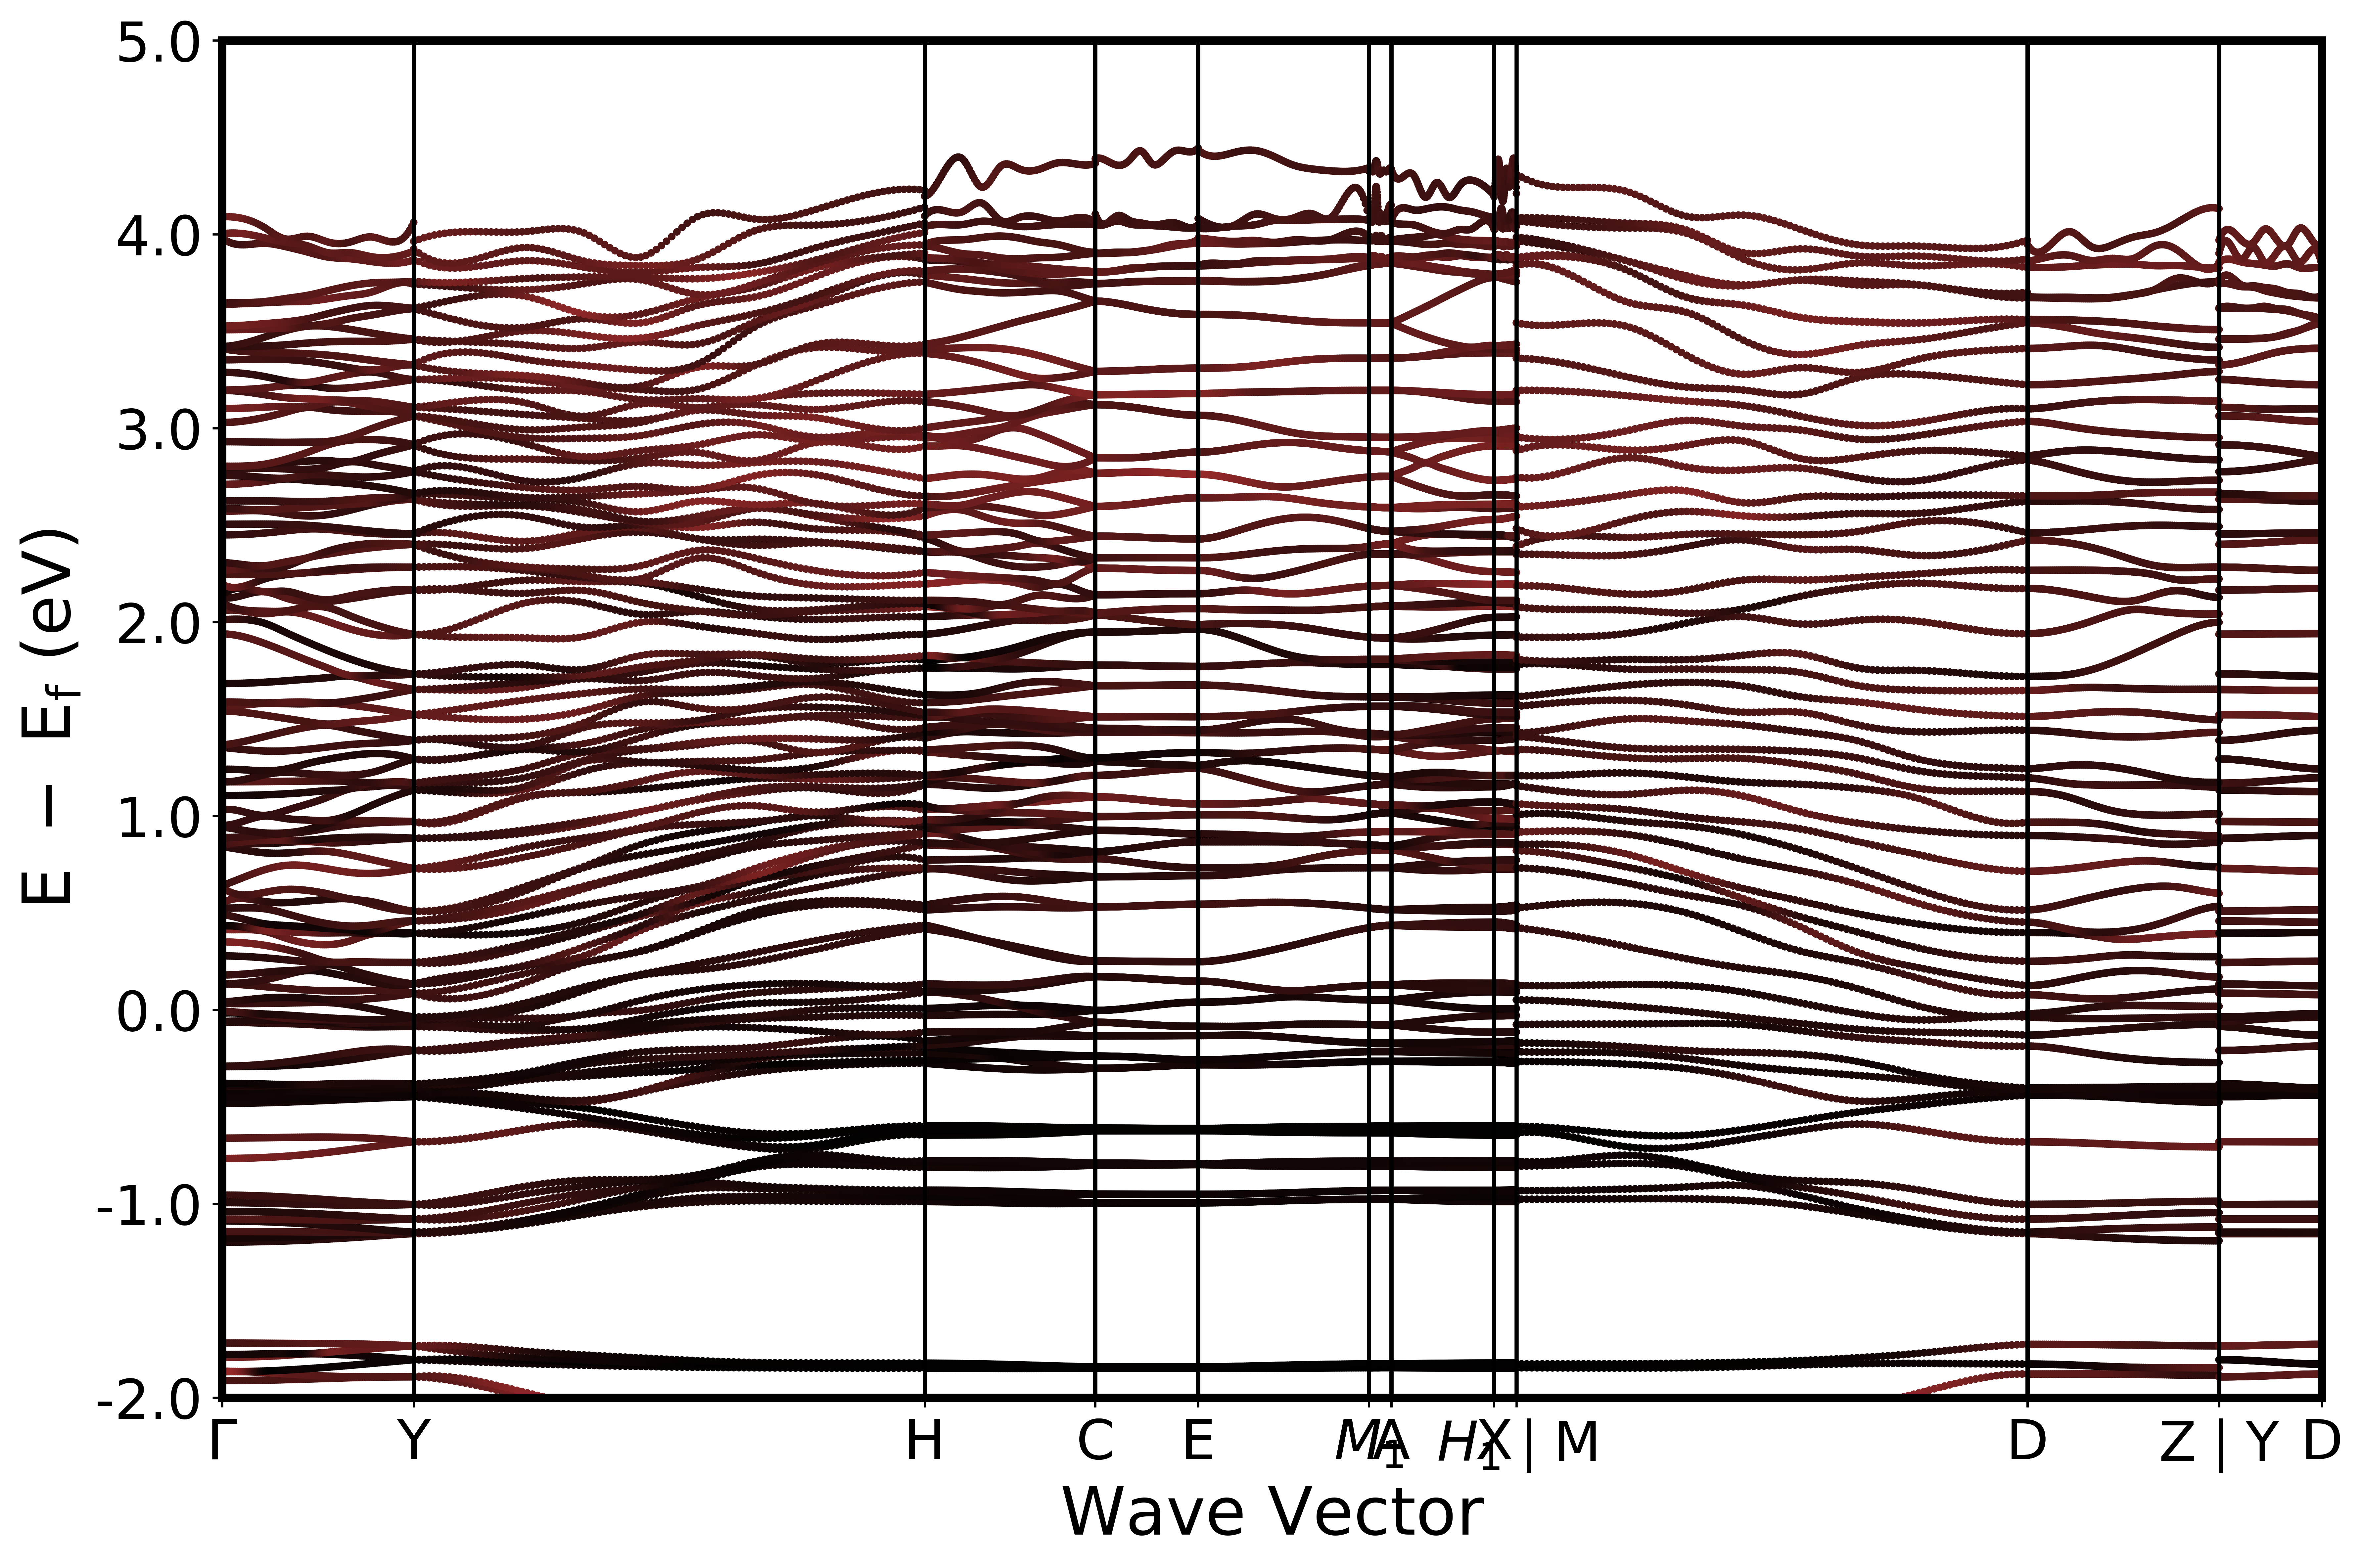

In [12]:
band_xlim = [0,4] # CHANGE ME
vbm_cbm_tolerance = [0.02, 0.06]
ylim = [-2,5]
dos_xlim = [-1,6]
line_width, font_size, marker = 3, 22, 22
savefig = True

# make_parchg_incar(root, bs, vbm_cbm_tolerance)
get_band_data(root, bs)
get_color_grouped(root, bsp, smooth=True, marker_size=3, ylim=ylim, savefig=savefig)
# band_labels, vbm, cbm = color_bs_dos_plotter(root, bsp, dosplot, smooth=True, marker_size=3, ylim=ylim, dos_xlim=dos_xlim, band_xlim=band_xlim, savefig=savefig)
# sexier_brillouin_plot(root, bsp, band_labels, line_width, font_size, marker, savefig=savefig)
# get_forces(root, outcar, structure, inorganics)

In [13]:
0.9549-0.9965

-0.04160000000000008

## Getting orbital contributions to band gap

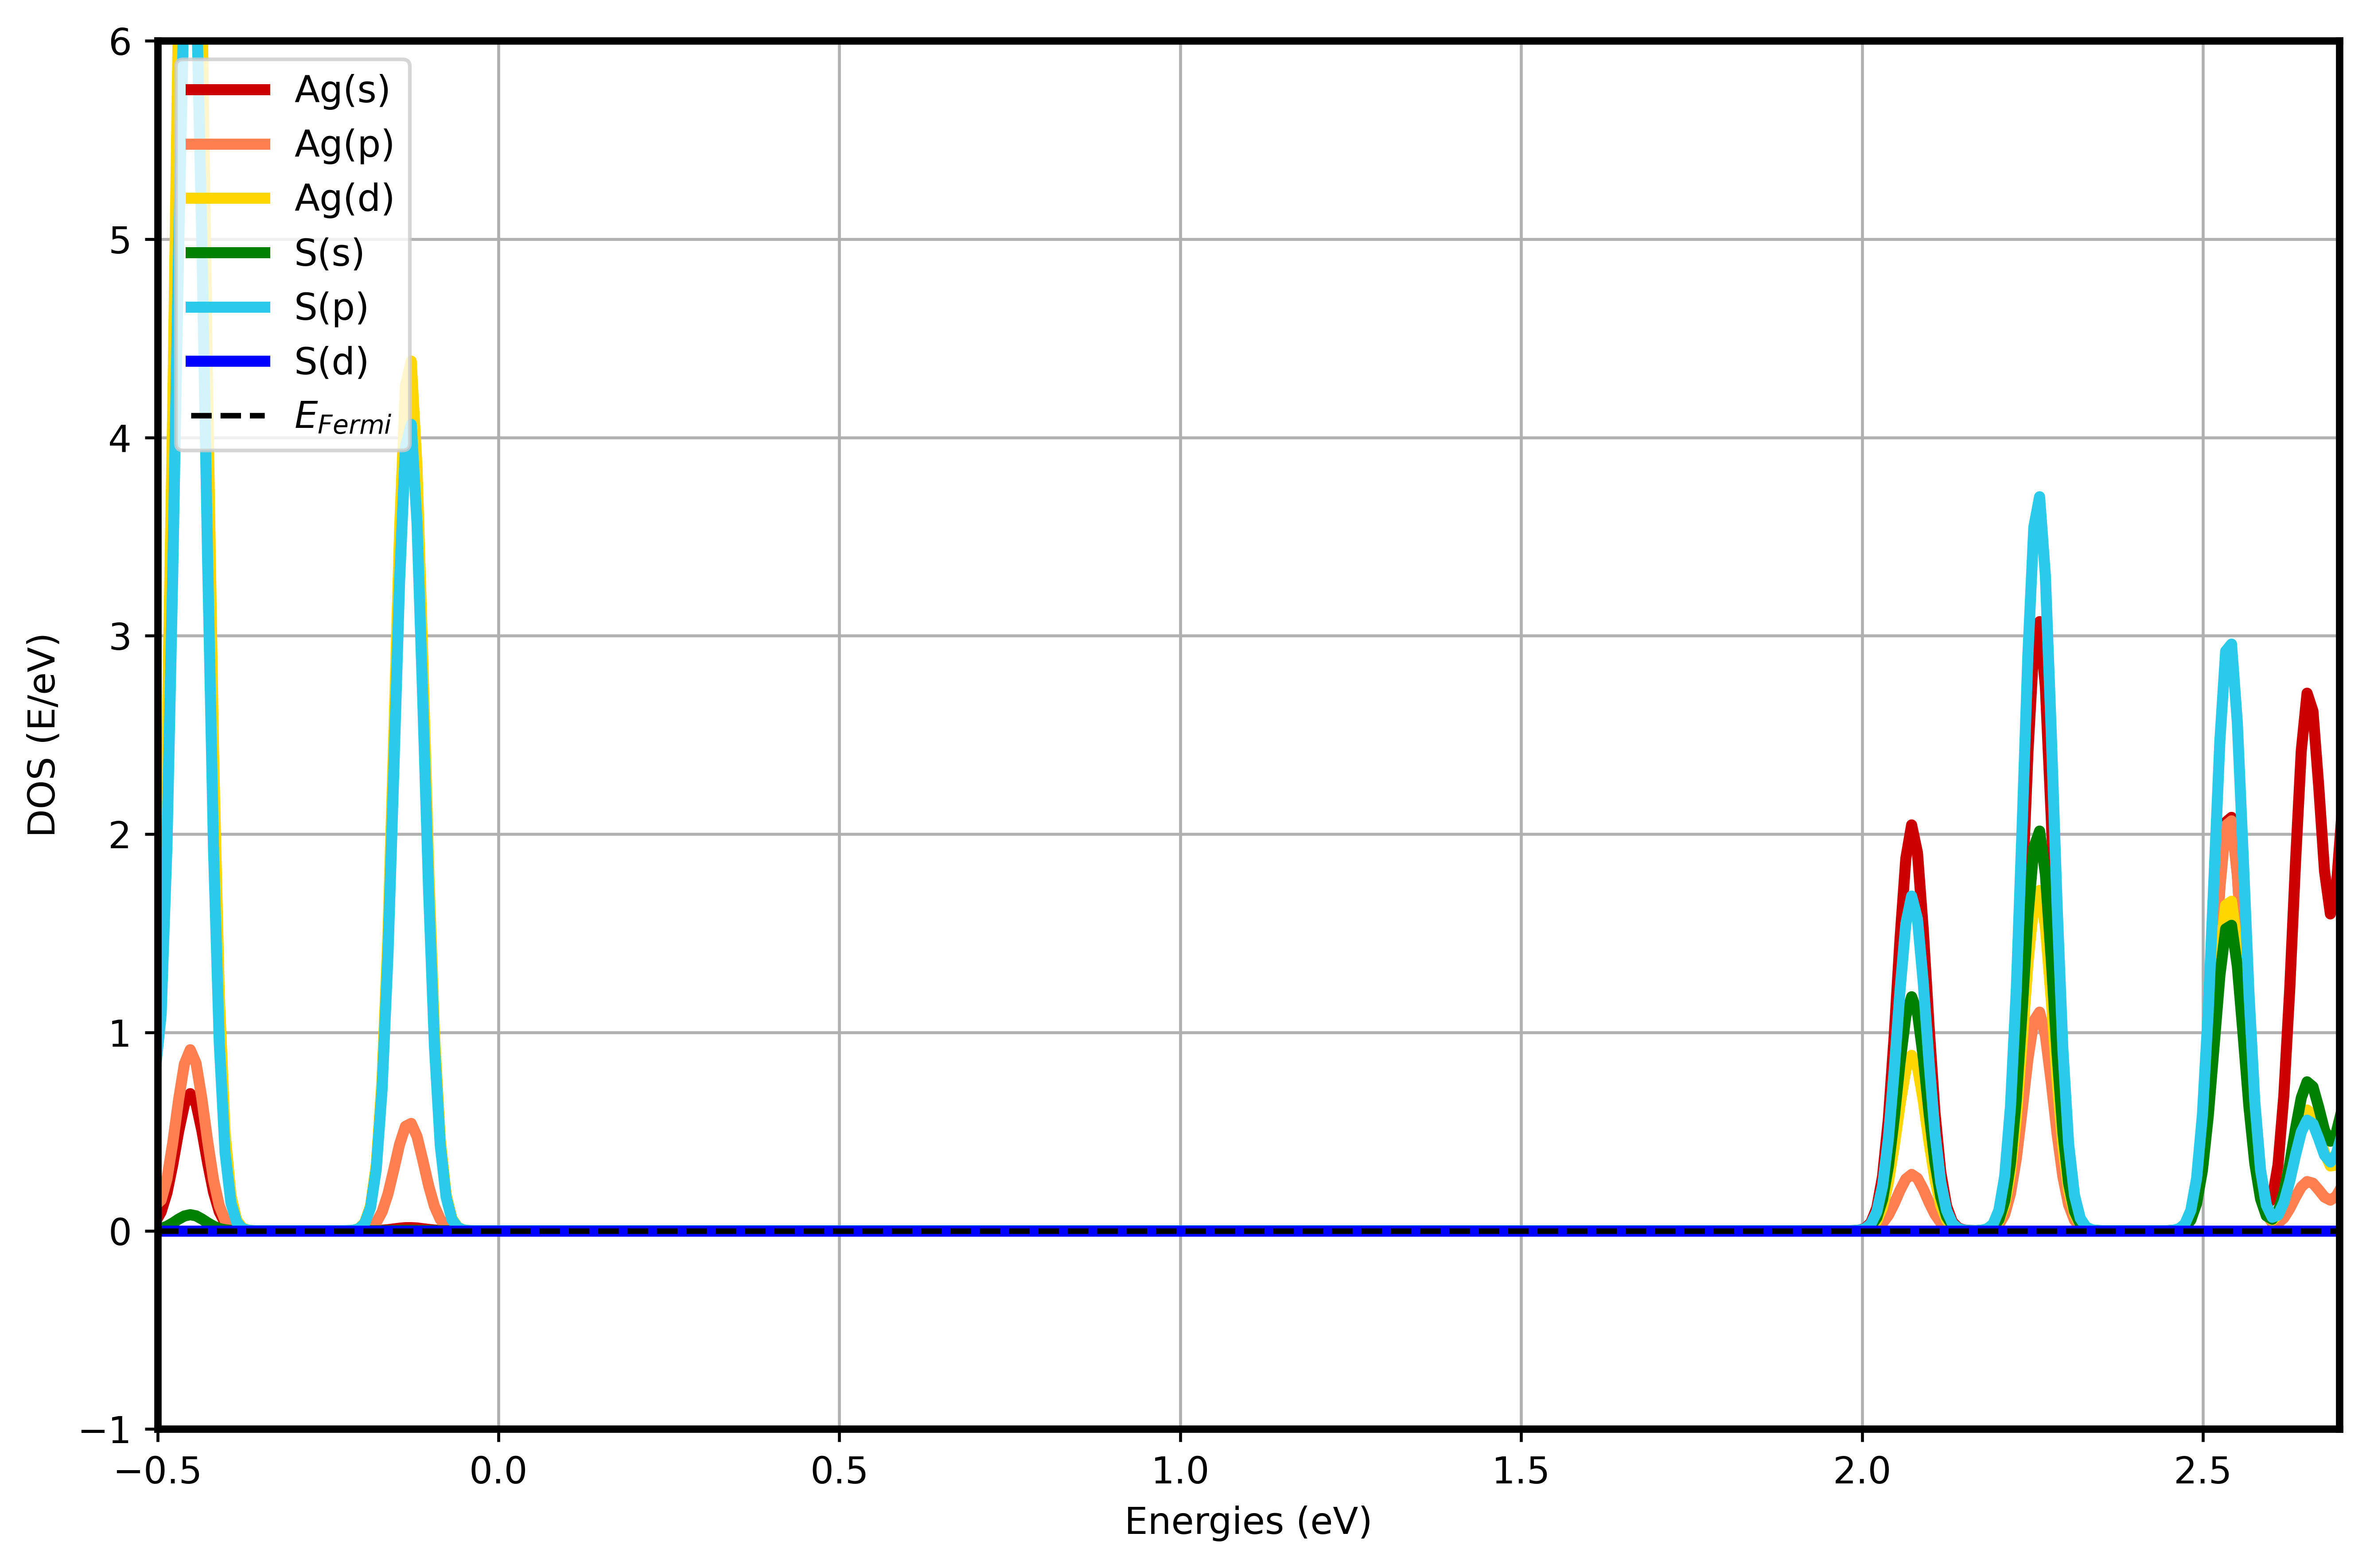

In [46]:
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/sugar_mochas/glu3_rtr_dehydrated/H-only_relax/"
species_of_interest = ["Ag", "S"]

structure = Structure.from_file(f"{root}/scf/POSCAR")
species, pdos_list = [],[]

for atom in range(len(structure)):
    if str(structure[atom].species)[:-1] in species_of_interest and str(structure[atom].species)[:-1] not in species:
        species.append(str(structure[atom].species)[:-1])

# orbital contribution
orbitals = {'s': OrbitalType.s, 'p': OrbitalType.p, 'd':OrbitalType.d, 'f':OrbitalType.f}
result = Vasprun(f'{root}/dos/vasprun.xml', parse_potcar_file=False)
complete_dos = result.complete_dos
for s in species:
    pdos_list.append(complete_dos.get_element_spd_dos(s))
orbital_pdos = DosPlotter()
for pdos, s in zip(pdos_list, species):
    for orbital in orbitals:
        if orbitals[orbital] in pdos.keys():
            orbital_pdos.add_dos(f'{s}({orbital})', pdos[orbitals[orbital]])

pretty_dos_plot(root, orbital_pdos, xlim=[-0.5, 2.7], ylim=[-1,6], savefig=savefig)

## Effective Mass

[0.9965, 3.4594]
The two k-points are equal
The two k-points are equal


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


(<Figure size 800x800 with 1 Axes>, <Axes: >)

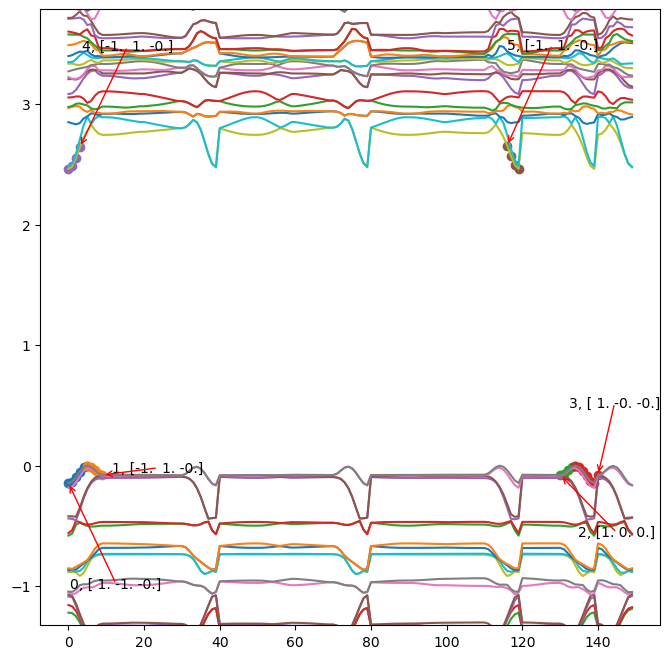

In [19]:
# root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/fluorescent_1D/Cu_2MMB_ORANGE/"
estruct_data = pd.read_csv(f"{root}/figures-and-data/estruct_energy_data.csv",index_col=0)
energies = [float(estruct_data["vbm"]), float(estruct_data["cbm"])]

print(energies)

data = inputs.DataVasp(f"{root}/band/OUTCAR", f"{root}/band/PROCAR")
settings = inputs.Settings(extrema_search_depth=0.075, energy_range=0.25)
bk_list = []
for i, en_list in enumerate(data.energies):
    for j, en in enumerate(en_list):
        for k in energies:
            diff = abs(k - en)
            # if diff < 0.004 and k == energies[1]:
            #     bk_list.append([i,j])
            if diff < 1e-4:
                bk_list.append([i,j])

segments = extrema.generate_segments(settings,data, bk = bk_list)
outputs.plot_segments(data,settings,segments)

## Visualizing segments of interest

-0.5962453182125256
-0.5844024774724762
-9.88242021860881
-0.5929744757316867
-0.5852252486491457
16.90924131561186
16.180886638644733
11.397843610781807
3.5983863526064654
3.6242990799762387


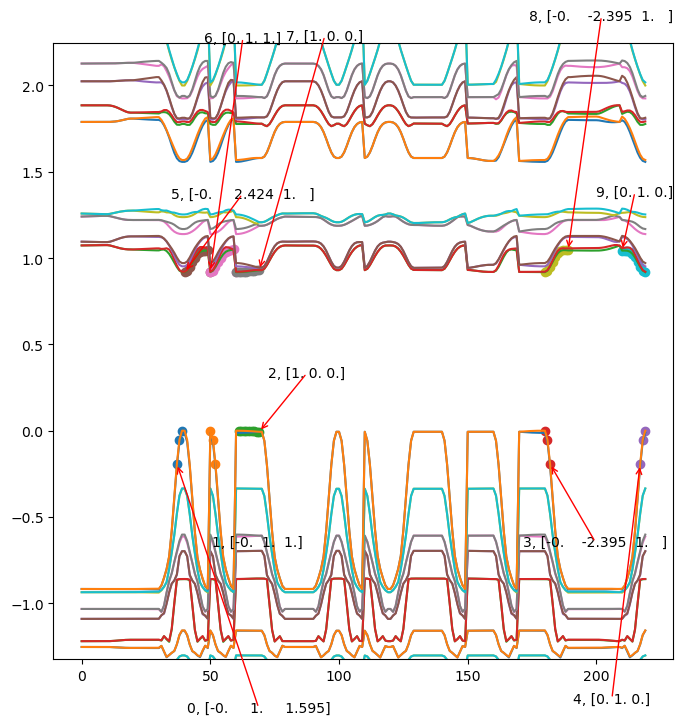

In [253]:
indices = [0,4]
outputs.plot_segments(data,settings,[segments[i] for i in indices])
for i in indices:
    print(segments[i].five_point_leastsq_effmass())

## Saving final data

              band  index  max curvature  finite diff  five-pt LSQ
0     valence_band      0      -0.000000    -2.250392    -1.991610
1  conduction_band      4       0.007304     1.023569     1.118745


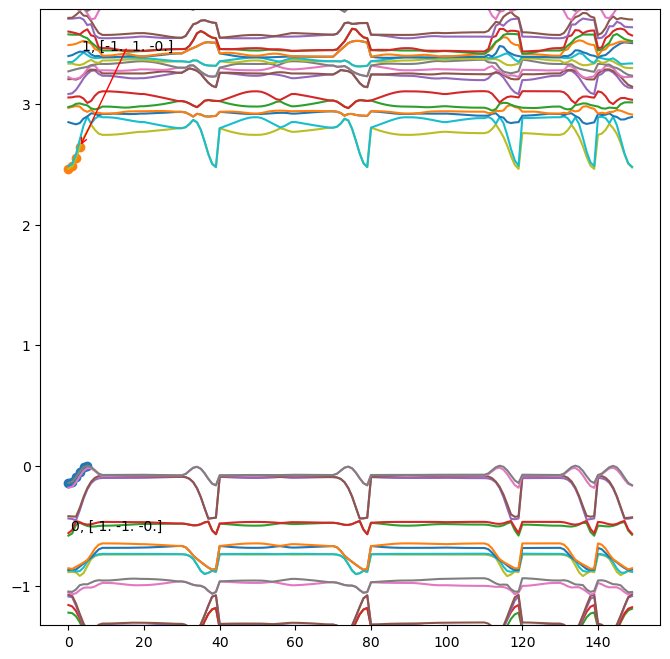

In [20]:
selected_indices = [0,4]
data_frame = []

for s in selected_indices:
    data_frame.append({"band": segments[s].band_type, 
       "index":s,
       "max curvature": max(segments[s].five_point_leastsq_fit()),
       "finite diff": segments[s].finite_difference_effmass(),
        "five-pt LSQ":segments[s].five_point_leastsq_effmass()})

df = pd.DataFrame(data_frame)
df.to_csv(f"{root}/figures-and-data/effective_mass.csv")
print(df)
outputs.plot_segments(data,settings,[segments[i] for i in selected_indices],savefig=True, random_int=1)
os.rename("/Users/adrianaladera/Desktop/MIT/research/CSE_thesis/notebooks/effmass_1.png", f"{root}/figures-and-data/effmass.png")

In [49]:
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/fluorescent_1D/"

mocha_list = ['AgS_2,6-dimethyl_RED', 'AgS_1-naphthyl_YELLOW', 'AgS_2-methyl_ester_1D_Lum_YELLOW', 
              'AgS_2-butane_GREEN', 'AgS_3-methoxy_YELLOW', 'AgS_2-methoxy_1D_Lum_GREEN',
              'AgSe_Py_RED', 'Au_SEtPh_low-temp_RED', 'Ag_2,6-dfSePh_2_YELLOW', 'Ag_2,6-dfSePh_1_YELLOW',
              'Cu_2MMB_ORANGE']

for mocha in mocha_list:
    print(mocha)
    bandrun = Vasprun(f"{root}/{mocha}/band/vasprun.xml", parse_projected_eigen=True)
    bs = bandrun.get_band_structure(f"{root}/{mocha}/band/KPOINTS")
    lattice =  Structure.from_file(f"{root}/{mocha}/band/POSCAR").lattice
    get_band_data(root, lattice, bs)

AgS_2,6-dimethyl_RED
     vbm     cbm    eFermi  bandgap transition
0  1.075  2.7434  2.611775   1.6684        b-Γ
AgS_1-naphthyl_YELLOW
      vbm     cbm    eFermi  bandgap transition
0  1.3292  2.9611  2.827193   1.6319        Γ-Γ
AgS_2-methyl_ester_1D_Lum_YELLOW
      vbm     cbm    eFermi  bandgap transition
0  1.4211  3.0314  1.598055   1.6103        Γ-Γ
AgS_2-butane_GREEN
      vbm     cbm    eFermi  bandgap transition
0  1.1357  3.1741  3.046581   2.0384        Γ-b
AgS_3-methoxy_YELLOW
      vbm     cbm    eFermi  bandgap transition
0  1.1459  3.2358  1.314878   2.0899        h-b
AgS_2-methoxy_1D_Lum_GREEN
      vbm     cbm    eFermi  bandgap               transition
0  1.5485  3.3909  1.745357   1.8424  (0.000,-0.000,-0.444)-f
AgSe_Py_RED
      vbm     cbm    eFermi  bandgap transition
0  1.4029  3.3021  1.533682   1.8992        c-a
Au_SEtPh_low-temp_RED
      vbm     cbm    eFermi  bandgap  \
0 -0.1496  3.3126  0.021062   3.4622   

                                  transition

/Users/adrianaladera/opt/anaconda3/envs/deeznuts/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:138: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn("Float overflow (*******) encountered in vasprun")


    vbm   cbm    eFermi  bandgap transition
0  None  None  5.399043      0.0       None
Ag_2,6-dfSePh_1_YELLOW


/Users/adrianaladera/opt/anaconda3/envs/deeznuts/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:138: UserWarning: Float overflow (*******) encountered in vasprun
  warnings.warn("Float overflow (*******) encountered in vasprun")


    vbm   cbm    eFermi  bandgap transition
0  None  None  6.178498      0.0       None
Cu_2MMB_ORANGE
     vbm     cbm    eFermi  bandgap transition
0  2.241  3.1598  3.032046   0.9188        Γ-Γ


In [50]:
root="/Users/adrianaladera/Desktop/MIT/research/mochas/VASP_calculations/sugar_mochas/"

mocha_list = ["glu3_rtr", "glu3_rtr_dehydrated", "galac_rtr", "galac_rtr_dehydrated"]

for mocha in mocha_list:
    print(mocha)
    bandrun = Vasprun(f"{root}/{mocha}/H-only_relax/band/vasprun.xml", parse_projected_eigen=True)
    bs = bandrun.get_band_structure(f"{root}/{mocha}/H-only_relax/band/KPOINTS")
    lattice =  Structure.from_file(f"{root}/{mocha}/H-only_relax/band/POSCAR").lattice
    get_band_data(root, lattice, bs)

glu3_rtr
      vbm     cbm    eFermi  bandgap transition
0  1.5088  3.7093  1.640522   2.2005        Γ-Γ
glu3_rtr_dehydrated
      vbm     cbm   eFermi  bandgap transition
0  1.4683  3.6631  1.60277   2.1948        f-Γ
galac_rtr
      vbm     cbm    eFermi  bandgap              transition
0  0.7802  3.7797  0.956616   2.9995  (0.000,0.000,-0.444)-d
galac_rtr_dehydrated
      vbm     cbm    eFermi  bandgap transition
0  1.0519  3.4573  1.206052   2.4054        a-e


In [61]:
root="/Users/adrianaladera/Desktop/AgS_2-methoxy_1D_Lum_GREEN_FINAL.vasp"

from ase.io import read
mocha = read(root)
print(mocha.get_atomic_numbers())

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  8  8  8  8  8  8  8  8
 16 16 16 16 16 16 16 16 47 47 47 47 47 47 47 47]
